# NCM, HVC Lesion "Effect Size" Analysis

This notebook is Leah's 6/28/22 work on quantifying "effect size" in different ways.

When running this notebook with the `SAVE_FIGS` flag set to True, the EPS files of the figures will be saved to `FIGDIR = "notebooks/figures/svg_originals"`.

The statistics reported in the paper are printed out in the corresponding section, and (when possible) printed in the same format as in used in the paper. Statistics are rounded to 2 decimal places, and p-values are rounded to 4 decimal places (so that we can report 3 decimal places in the paper, or "< 0.001") 

## 1 Reading the data

Reading the data is facilitated by the class `zf_data.Tsvk`, which provides some helper methods to compute quantities used in the paper/figures. The name "Tsvk" refers to the term $T^{sv}_k$ from the methods used to compute $p(\mathrm{int}|s,v,k)$ --- that is the probability that subject $s$ interrupts a particular vocalizer $v$, given that it has seen $k$ informative trials of that vocalizer. 

Note that this data structure is not required for any analyses, since the raw data can be loaded directly from `zebra-finch-memory-lesions/data/behavior/TrialData.csv` and processed however you choose. However, it can be far more convenient to use this structure since it predefines methods used to perform the analyses found in the paper.

We also provide a helper functino `zf_data.load_trials()` for loading the TrialData.csv, which returns a pandas DataFrame containing all operant trials for all subjects.

```python
from zf_data import load_trials
df = load_trials()
```

## 2 Using the Tsvk data structure

A `Tsvk` instance is initialized with (1) a pandas DataFrame containing a filtered subset of operant trials, and (2) a value of `k_max`, the largest informative trial bin to include in the analysis.

```python
from zf_data import Tsvk
tsvk = Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=11)
```

### Methods

Here are some of the helper methods `Tsvk` defines

* `tsvk.p(subject, vocalizer, k)`
    > Averages $p(\mathrm{int}|s,v,k)$ over vocalizers. Use `Tsvk.re.p(...)` and `Tsvk.nore.p(...)` to restrict it to either Re or NoRe vocalizers respectively.

* `tsvk.re.p_by_k()`, `Tsvk.nore.p_by_k()`
    > for each $k$, estimates $p(\mathrm{int}|Re,k)$ and $p(\mathrm{int}|NoRe,k)$ by jackknifing over subjects. These are used to produce the group average learning curves in Figure 3A and 3B.

* `tsvk.re.odds_by_subjects(k)`, `Tsvk.nore.odds_by_subjects(k)`
    > for each $k$, computes odds of interrupting Re or NoRe vocalizers of each subject

* `tsvk.logOR_by_subjects(k)`
    > for each $k$, compute
    $$
    \mathrm{logOR}(s, k)=\mathrm{log}(Odds(\mathrm{int}|s,NoRe,k)) - \mathrm{log}(Odds(\mathrm{int}|s,Re,k))
    $$
    for each subject, returning it in a pandas DataFrame

* `tsvk.logOR()`
    > Computes $\mathrm{logOR}(k)$ for $k \in \{0, .., k_{max}\}$. At each $k$, the estimate and SEM is estimated using a jackknife procedure over subjects, returning it in a pandas DataFrame. The condition $\mathrm{logOR}(k) > 0$ is tested with a one-sided paired t-test over subjects. The Benjamini-Hochberg false discovery correction used in the paper should be applied after calling this method.

* `tsvk.fisher_exact()`
    > Computes the result of a Fisher exact test on the entire DataFrame, with the following contingency matrix. The Fisher exact test returns the estimate of $\mathrm{OR}=\frac{ad}{bc}$, 95% confidence bounds on the estimate, and a p-value. 

|         |Interruptions|Waits|
|---------|:-:|:-:|
|NoRe     | a | c |
|Re       | b | d |

### Note on caching results

Computing the quantities used in the paper can be relatively slow (10s of seconds). Each `Tsvk` instance caches the result of most of its methods when they are called once, so that re-running a cell happens relatively instantaneously.

Sometimes multiple figures/analyses operate on the same subset of data (e.g. the top and bottom figures of Figure 3A and 3B). To avoid re-instantiating a `Tsvk` instance for each analysis (which would cause all the computations to be re-run), a function called `get_or_create_Tsvk` is defined in this notebook which restores a previous `Tsvk` instance if the dataframe and k_max parameter are identical.

## 3 Typical analysis pattern


The pattern used in this notebook is usually:

1. Instantiate a Tsvk object for one or more ranges of data (e.g. S1 & prelesion), e.g.

```python
tsvk = get_or_create_Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=11)
```

2. Compute some quantity or quantities of interest, e.g.

```python
re_probabilities = tsvk.re.p_by_k()
nore_probailities = tsvk.nore.p_by_k()
```

3. Plot or perform statistics on the returned quantities, e.g.

```python
import matplotlib.pyplot as plt
plt.errorbar(re_probabilities.k, re_probabilities.logOR, y_err=2 * re_probabilities.SE)
plt.errorbar(nore_probabilities.k, nore_probabilities.logOR, y_err=2 * nore_probabilities.SE)
```

In [1]:
import os
import sys

In [23]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import statsmodels
import statsmodels.api as sm
import statsmodels.regression
import statsmodels.formula.api as smf
from matplotlib.gridspec import GridSpec
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.oneway import anova_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import permutation_test

from zf_data import Tsvk, load_trials
from zf_data.load_data import load_lesion_summary_table
from zf_data.plotting import (
    border,
    color_by_reward,
    draw_k_axis,
    draw_logor_axes_markers,
    draw_probability_axes_markers,
    plot_pecking_test_data,
    figure_cm,
    fig_grid,
    smoothhist,
    shaded_line,
)
from zf_data.stats import false_discovery, likelihood_ratio_test, two_to_one_tail
from zf_data.utils import parse_p, setup_mpl_params
from zf_data.constants import *

## Notebook Settings

In [3]:
# Set matplotlib axes to default grey using zf_data.utils Kevin wrote
setup_mpl_params()

In [4]:
# This code is for troubleshooting / writing.  It is an ipython "magic" command that will autoreload modules.
# This makes it possible to edit various functions in a text editor, then call the function again and
# get a different behavior, because the module is reloaded each time the function is called.
# Not sure it is necessary unless active editing is happening.

%load_ext autoreload
%autoreload 2

In [5]:
SAVE_FIGS = False  #@param {type: "boolean"}
FIGDIR = "figures/svg_originals"  #@param {type: "string"}
FIGDIR = Path(FIGDIR)  # pathlib Path() function turns string into Path object 

# Create the folder for figure outputs
FIGDIR.mkdir(parents=True, exist_ok=True)  #from Pathlib .mkdir function not os .mkdir function

# little helper function for saving later... 
def savedir(rel_path):
    """Return the save path relative to FIGDIR"""
    return str(FIGDIR / rel_path)

In [6]:
# JNeurosci column sizes in cm, see https://www.jneurosci.org/content/information-authors
COL1 = 8.5  #@param {type: "number"}
COL1_5 = 11.6  #@param {type: "number"}
COL2 = 17.6  #@param {type: "number"}

### Helper functions

In [7]:
def get_or_create_Tsvk(df: pd.DataFrame, k_max: int = None) -> Tsvk:
    """Create a Tsvk instance from a dataframe, or return a cached one for that data
    
    If the df.index and k_max match a previously computed Tsvk, return that one. Otherwise,
    instantiate a new Tsvk() instance.
    
    Tsvk instances are hashed by a tuple of the dataframe index and k_max requested.
    """
    key = (tuple(df.index), k_max)
    if key not in get_or_create_Tsvk.cache:
        get_or_create_Tsvk.cache[key] = Tsvk(df, k_max=k_max)
    return get_or_create_Tsvk.cache[key]
get_or_create_Tsvk.cache = {}

def test_get_or_create_Tsvk(df: pd.DataFrame):
    backup = get_or_create_Tsvk.cache.copy()
    get_or_create_Tsvk.cache = {}
    t1 = get_or_create_Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=11)
    t2 = get_or_create_Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=11)
    t3 = get_or_create_Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=12)
    t4 = get_or_create_Tsvk(df[(df.LesionStage == "postlesion") & (df.VocalizerSet == "S2")], k_max=12)
    
    assert t1 is t2
    assert t1 is not t3
    assert t2 is not t3
    assert t1 is not t4
    assert t2 is not t4
    print("Tests pass")
    
    get_or_create_Tsvk.cache = backup

## Load data

In [8]:
df = load_trials()

In [9]:
test_get_or_create_Tsvk(df)

Tests pass


## Speaker output problems

Sessions on Nov 20, 2020 had technical issues with audio output where speakers in two subjects (BluWhi3230M, HVC) and (GreWhi2703M, HVC), where audio stopped playing audio partway through the session. Four subjects were affected, all in the HVC group, and the sessions were postlesion S1 for 6v6-d2 DCs (BluWhi3230M) and 8v8-d2 Songs (GreWhi2703M). Audio went out at about 12:00. We exclude data on this day after this time.

Here I load that extra data and plot it to show what data is excluded.

In [10]:
from zf_data.load_data import EXCLUSION_SUBJECTS, EXCLUSION_DATE, EXCLUSION_TIME
full_df = load_trials(valid_only=False)

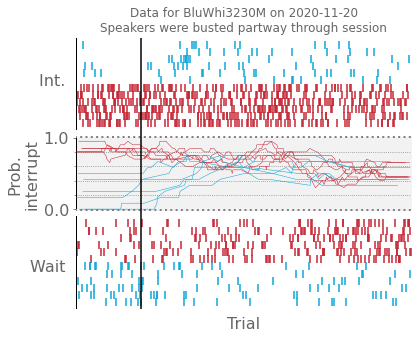

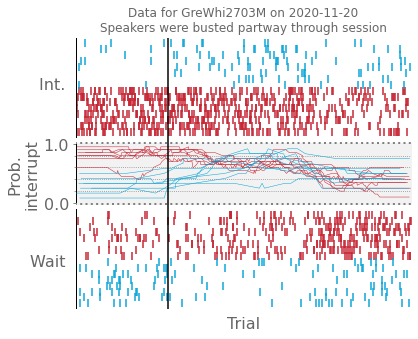

In [11]:
for subject in EXCLUSION_SUBJECTS:
    subj_df = full_df[(full_df.Date == EXCLUSION_DATE) & (full_df.Subject == subject)]
    exclusion_df = full_df[
        (full_df.Date == EXCLUSION_DATE)
        & (full_df.Time > EXCLUSION_TIME)
        & (full_df.Subject == subject)
    ]
    exclusion_first_index = exclusion_df.Trial.iloc[0]
    
    fig = plot_pecking_test_data(
        subj_df,
        ["StimulusClass", "StimulusVocalizerId", "StimulusCallType"],
        ticks=True,
        figsize=(6, 5),
        linekwargs={"linewidth": 0.5},
        mark_days=True
    )
    plt.vlines([exclusion_first_index], *plt.ylim(), color="Black", label="Speakers stopped playing audio after")
    plt.title(f"Data for {subject} on 2020-11-20\nSpeakers were busted partway through session")
    plt.show()
    plt.close(fig)

## Fig 4-E Effect Size on MEMORY (/Recall)

I will plot a new panel for Fig 4 or a replacement for Fig 4 B or C.  I'll call it Fig 4-E for now for "effect size."  This plot is "effect size as a function of informative trials", and it compares performance on Set 1 (previously learned stimuli) between NCM lesioned birds and non-NCM lesioned birds (both HVC and control birds are lumped together). 

The calculation is similar to a d' measurement, except instead of d' being a measure of discriminability between two stimuli, " d' " here is the difference in the (mean) odds ratios between NCM lesioned and ~NCM lesioned birds' performance.  This is the calculation, which will be performed at each k value: 

d' =  <u>2( mean of log(OR)~NCM - mean of log(OR)NCM )</u>

       sqrt( variance~NCM^2 + varianceNCM^2 )
         
This way, the measurement of "effect size" is normalized by the standard deviation (it's not really a psychophysical measurement, but it's calculated the same way as d')

In [12]:
## First I will plot the performance of birds on Set 1 on days 4 and 5 of the learning ladder.
## This is Fig 3B lower panel

def figure3b_odds(ax: plt.Axes = None):
    """Plots learning curves for final stage of ladder before lesion"""
    if ax is None:
        ax = plt.gca()
        
    # Get prelesion data (late in learning) 
    tsvk = get_or_create_Tsvk(df[
        (df.LesionStage == "prelesion")
        & (df.VocalizerSet == "S1")
        & df.LadderStage.isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])
    ], k_max=11)

    # Get odds-ratio (avg over subjects) for each k
    logOR = tsvk.logOR()
    
    # shaded_line() is a function found in zf_data.plotting it uses fill_between() 
    shaded_line(
        logOR["k"], 
        logOR["logOR"], 
        2 * logOR["SE"],
        ax=ax
    )
    
    pvalues = logOR["pvalue"]
    first_bin = np.where(false_discovery(pvalues, alpha=0.05))[0][0]
    
    print("Figure 3B (Bottom)")
    print("------------------")
    print("   Red dotted = HVC; Black dotted = control; Green = NCM;")
    print("   Blue = average of all with 2 SEM shaded")
    print(f"  On days 6v6-d2/8v8-d2 for pre-lesion learning of S1")
    print(f"  the smallest bin k where log2OR > 0 could be detected: k={first_bin}")
    print(f"    k=0; logOR = {logOR['logOR'][0]:.2f}, t({logOR['dof'][0]}) = {logOR['tstat'][0]:.2f}, {parse_p(pvalues[0])}")

    # Draw overlay lines showing the logOR of each individual group

    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "prelesion")
            & (df.VocalizerSet == "S1")
            & (df.SubjectTreatment == treatment)
            & df.LadderStage.isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])
        ], k_max=11)

        logOR = tsvk_treatment.logOR()

        ax.plot(
            logOR["k"], 
            logOR["logOR"], 
            **{
                "linestyle": LINEMAP[treatment],
                "color": COLORMAP[treatment],
                "zorder": -1,
                "linewidth": 1,
            },
        )

Figure 3B (Bottom)
------------------
   Red dotted = HVC; Black dotted = control; Green = NCM;
   Blue = average of all with 2 SEM shaded
  On days 6v6-d2/8v8-d2 for pre-lesion learning of S1
  the smallest bin k where log2OR > 0 could be detected: k=0
    k=0; logOR = 2.40, t(20) = 3.61, p = 0.001 (***)


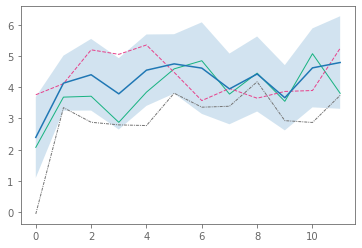

In [13]:
figure3b_odds()

In [14]:
## Now I will try a Fig3B_odds but lump HVC and control together
def fig3b_odds_NCM_vs_nonNCM(ax: plt.Axes = None):
    """Plots learning curves for final stage of ladder before lesion"""
    if ax is None:
        ax = plt.gca()
        
    # Get prelesion data (late in learning) 
    tsvk = get_or_create_Tsvk(df[
        (df.LesionStage == "prelesion")
        & (df.VocalizerSet == "S1")
        & df.LadderStage.isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])
    ], k_max=11)

    # Get odds-ratio (avg over subjects) for each k
    # the next two lines are used for the blue line average and shaded area SE 
    # shaded_line() is a function found in zf_data.plotting it uses fill_between() 
    
    logOR = tsvk.logOR()
    
    shaded_line(
        logOR["k"], 
        logOR["logOR"], 
        2 * logOR["SE"],
        ax=ax
    )
    
    pvalues = logOR["pvalue"]
    first_bin = np.where(false_discovery(pvalues, alpha=0.05))[0][0]
    
    print("Figure 3B Bottom Modified")
    print(" Last two days of song ladder")
    print(" logOR versus infomative trials k")
    print("-----------------------------------")
    print(f"  Specifically days 6v6-d2/8v8-d2 for pre-lesion learning of S1")
    print(f"  the smallest bin k where log2OR > 0 could be detected: k={first_bin}")
    print(f"    k=0; logOR = {logOR['logOR'][0]:.2f}, t({logOR['dof'][0]}) = {logOR['tstat'][0]:.2f}, {parse_p(pvalues[0])}")
    print(f"   Black dotted = control and HVC; Green = NCM;")
    print(f"   Blue = average of all with 2 SEM shaded")
    
    # Draw overlay lines showing the logOR of each individual group

    for treatment in ["NCM", ("HVC", "CTRL")]:
        if isinstance(treatment, str):
            treatment_filter = df.SubjectTreatment == treatment
            plot_name = treatment
        elif isinstance(treatment, tuple):
            treatment_filter = np.zeros_like(df.SubjectTreatment).astype(bool)
            plot_name = "CTRL"  # TODO change this to new color?  in zf_data.constants
            for t in treatment:
                treatment_filter |= df.SubjectTreatment == t
        
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "prelesion")
            & (df.VocalizerSet == "S1")
            & df.LadderStage.isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])
            & treatment_filter
        ], k_max=11)

        logOR = tsvk_treatment.logOR()

        ax.plot(
            logOR["k"], 
            logOR["logOR"], 
            **{
                "linestyle": LINEMAP[plot_name],
                "color": COLORMAP[plot_name],
                "zorder": -1,
                "linewidth": 1,
            },
        )

Figure 3B Bottom Modified
 Last two days of song ladder
 logOR versus infomative trials k
-----------------------------------
  Specifically days 6v6-d2/8v8-d2 for pre-lesion learning of S1
  the smallest bin k where log2OR > 0 could be detected: k=0
    k=0; logOR = 2.40, t(20) = 3.61, p = 0.001 (***)
   Black dotted = control and HVC; Green = NCM;
   Blue = average of all with 2 SEM shaded


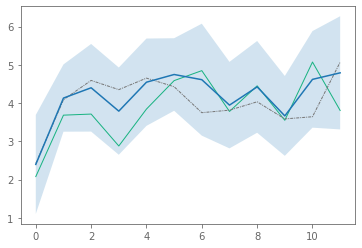

In [15]:
fig3b_odds_NCM_vs_nonNCM()

In [16]:
# Now here is Fig 4B
def figure4b(ax: plt.Axes = None):
    """Plots odds ratios of lesioned birds during initial stage of ladder AFTER lesion"""
    if ax is None:
        ax = plt.gca()

    print("Figure 4B")
    print("---------")

    # Overlay odds ratio curves for each treatment type

    for treatment in ["NCM", "HVC", "CTRL", ("HVC", "CTRL")]:
        if isinstance(treatment, str):
            treatment_filter = df.SubjectTreatment == treatment
        elif isinstance(treatment, tuple):
            treatment_filter = np.zeros_like(df.SubjectTreatment).astype(bool)
            for t in treatment:
                treatment_filter |= df.SubjectTreatment == t
                
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S1")
            & treatment_filter
        ], k_max=11)

        logOR = tsvk_treatment.logOR()
        
        if isinstance(treatment, str):
            shaded_line(
                logOR["k"], 
                logOR["logOR"], 
                2 * logOR["SE"],
                ax=ax,
                line_kwargs={
                    "color": COLORMAP[treatment],
                    "linestyle": LINEMAP[treatment],
                },
            )
        else:
            print(f"Computing combined treatments, {treatment}")
            print(f"==========================================")
        
        pvalues = logOR["pvalue"]
        first_bin = np.where(false_discovery(pvalues, alpha=0.05))[0][0]
        
        print(f" The {treatment} group after lesion, being re-exposed to S1")
        print("--------")
        print(f"  the smallest bin k where log2OR > 0 could be detected: k={first_bin}")        

        print(f"    k=0; {treatment}: logOR = {logOR['logOR'][0]:.2f}, t({logOR['dof'][0]}) = {logOR['tstat'][0]:.2f}, {parse_p(pvalues[0])}")
        print(f"    k=1; {treatment}: logOR = {logOR['logOR'][1]:.2f}, t({logOR['dof'][1]}) = {logOR['tstat'][1]:.2f}, {parse_p(pvalues[1])}")
        print()

Figure 4B
---------
 The NCM group after lesion, being re-exposed to S1
--------
  the smallest bin k where log2OR > 0 could be detected: k=1
    k=0; NCM: logOR = -0.54, t(9) = -0.68, p = 0.742
    k=1; NCM: logOR = 1.04, t(9) = 2.71, p = 0.012 (*)

 The HVC group after lesion, being re-exposed to S1
--------
  the smallest bin k where log2OR > 0 could be detected: k=0
    k=0; HVC: logOR = 1.42, t(6) = 4.05, p = 0.003 (**)
    k=1; HVC: logOR = 3.50, t(6) = 7.41, p < 0.001 (***)

 The CTRL group after lesion, being re-exposed to S1
--------
  the smallest bin k where log2OR > 0 could be detected: k=1
    k=0; CTRL: logOR = 1.24, t(3) = 1.19, p = 0.160
    k=1; CTRL: logOR = 1.96, t(3) = 2.80, p = 0.034 (*)

Computing combined treatments, ('HVC', 'CTRL')
 The ('HVC', 'CTRL') group after lesion, being re-exposed to S1
--------
  the smallest bin k where log2OR > 0 could be detected: k=0
    k=0; ('HVC', 'CTRL'): logOR = 1.36, t(10) = 3.32, p = 0.004 (**)
    k=1; ('HVC', 'CTRL'): logOR

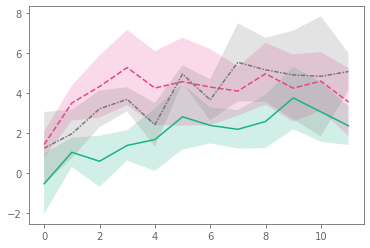

In [17]:
figure4b()

In [18]:
# Now let's modify Fig4b to combine HVC and control birds.  Above, they are plotted as HVC = red and ctrl = grey
# Here I will combine HVC and control into one grey line (leaving NCM green)

def fig4b_modified(ax: plt.Axes = None):
    """Plots odds ratios of lesioned birds during initial stage of ladder AFTER lesion"""
    if ax is None:
        ax = plt.gca()

    print("Figure 4B modified")
    print("-------------------")
    print("Grey = control and HVC; Green = NCM" )
    print("-------------------------------------")

    # Overlay odds ratio curves for each treatment type

    for treatment in ["NCM", ("HVC", "CTRL")]:
        if isinstance(treatment, str):
            treatment_filter = df.SubjectTreatment == treatment
            plot_name = treatment
        elif isinstance(treatment, tuple):
            treatment_filter = np.zeros_like(df.SubjectTreatment).astype(bool)
            plot_name = "CTRL"  # TODO change this to new color?  in zf_data.constants
            for t in treatment:
                treatment_filter |= df.SubjectTreatment == t
                
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S1")
            & treatment_filter
        ], k_max=11)

        logOR = tsvk_treatment.logOR()
        
        shaded_line(
            logOR["k"], 
            logOR["logOR"], 
            2 * logOR["SE"],
            ax=ax,
            line_kwargs={
                "color": COLORMAP[plot_name],
                "linestyle": LINEMAP[plot_name],
            }
        )
        
        pvalues = logOR["pvalue"]
        first_bin = np.where(false_discovery(pvalues, alpha=0.05))[0][0]
        
        print(f" The {treatment} group after lesion, being re-exposed to S1")
        print("-----------------")
        print(f"  the smallest bin k where log2OR > 0 could be detected: k={first_bin}")        

        print(f"    k=0; {treatment}: logOR = {logOR['logOR'][0]:.2f}, t({logOR['dof'][0]}) = {logOR['tstat'][0]:.2f}, {parse_p(pvalues[0])}")
        print(f"    k=1; {treatment}: logOR = {logOR['logOR'][1]:.2f}, t({logOR['dof'][1]}) = {logOR['tstat'][1]:.2f}, {parse_p(pvalues[1])}")
        print()

Figure 4B modified
-------------------
Grey = control and HVC; Green = NCM
-------------------------------------
 The NCM group after lesion, being re-exposed to S1
-----------------
  the smallest bin k where log2OR > 0 could be detected: k=1
    k=0; NCM: logOR = -0.54, t(9) = -0.68, p = 0.742
    k=1; NCM: logOR = 1.04, t(9) = 2.71, p = 0.012 (*)

 The ('HVC', 'CTRL') group after lesion, being re-exposed to S1
-----------------
  the smallest bin k where log2OR > 0 could be detected: k=0
    k=0; ('HVC', 'CTRL'): logOR = 1.36, t(10) = 3.32, p = 0.004 (**)
    k=1; ('HVC', 'CTRL'): logOR = 3.00, t(10) = 6.42, p < 0.001 (***)



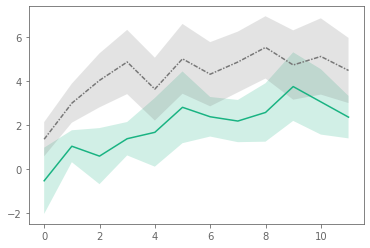

In [19]:
fig4b_modified()

In [20]:
# OK at last, lets plot the unitless "effect size" versus informative trials

def fig4e(ax: plt.Axes = None):
    """Plots effect size of NCM lesion during initial stage of ladder AFTER lesion
        NCM birds are compared to "control", which in this case is HVC + CTRL condition birds lumped together
        
        effect size = d' = (sqrt(2) * difference_in_logORs_CTRL-NCM) / normalized_variance
        
        specifically: 
                        difference_in_logORs_CTRL-NCM = logOR_CTRL - logOR_NCM
                        normalized_variance =  sqrt(var_NCM * (NCM_dof+1) + var_CTRL * (CTRL_dof+1) / 
                                                                ((NCM_dof+1) + (CTRL_dof+1)))
        """
    if ax is None:
        ax = plt.gca()

    print("Figure 4e : NCM lesion effect on recall")
    print("-----------------------------------------")
    print(" effect size = (sqrt(2) * difference_in_logORs_CTRL-NCM) / ")
    print("                  / normalized_variance ")
    print(" ")
    print(" Set 1 vocalizers")

    # create two separate tsvk instances, one for control group one for NCM

    tsvk_NCM = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S1")
        & (df.SubjectTreatment == "NCM")
    ], k_max=11)
    logOR_NCM = tsvk_NCM.logOR()
    
    treatment_filter = np.zeros_like(df.SubjectTreatment).astype(bool)
    for t in ("HVC", "CTRL"):
        treatment_filter |= df.SubjectTreatment == t
    
    tsvk_control = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S1")
        & treatment_filter
    ], k_max=11)
    logOR_CTRL = tsvk_control.logOR()
    
    # difference of the logORs
    diff_logOR = logOR_CTRL["logOR"]-logOR_NCM["logOR"]
    
    # normalization term
    nNCM = logOR_NCM["dof"] + 1
    nCTRL = logOR_CTRL["dof"] + 1
    var_NCM = logOR_NCM["SE"]**2 * nNCM 
    var_CTRL = logOR_CTRL["SE"]**2 * nCTRL
    norm_var = np.sqrt(var_NCM * nNCM + var_CTRL * nCTRL / (nNCM + nCTRL))
    
    # effect size of NCM lesion on memory
    d_prime = (np.sqrt(2) * diff_logOR) / norm_var
    
    # an attempt at an SE measurement for d'... I don't think this is right
    SE_average = np.sqrt((logOR_NCM["SE"]**2 * logOR_NCM["dof"] + logOR_CTRL["SE"]**2 * logOR_CTRL["dof"]) / (logOR_NCM["dof"] + logOR_CTRL["dof"]))
    
    shaded_line(
        logOR_NCM["k"], 
        d_prime, 
        SE_average/500, # I'm not actually sure what to calculate for SE here
        ax=ax,
        line_kwargs={
            "color": [1.0, 0.5, 0.25],
            "linestyle": LINEMAP["HVC"],
        }
    )

Figure 4e : NCM lesion effect on recall
-----------------------------------------
 effect size = (sqrt(2) * difference_in_logORs_CTRL-NCM) / 
                  / normalized_variance 
 
 Set 1 vocalizers


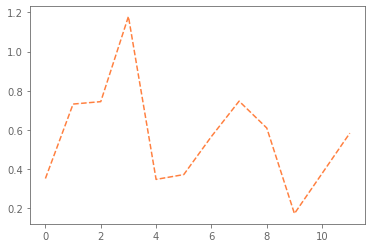

In [25]:
fig4e()

## Fig 5-E Effect Size on LEARNING

This plot is the same as above, except that now I'm working with performance on Set 2, which are songs that the birds did not learn before lesion.

In [26]:
# Original Fig 5b for comparison
def figure5b(ax: plt.Axes = None):
    """Plots odds-ratios for learning a new vocalizer set S2"""
    if ax is None:
        ax = plt.gca()

    print("Figure 5B")
    print("------------------")
    for treatment in ["NCM", "HVC", "CTRL"]:
        print(COLORMAP[treatment] + " is " + treatment)
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S2")
            & (df.SubjectTreatment == treatment)
        ], k_max=11)

        logOR = tsvk_treatment.logOR()

        shaded_line(
            logOR["k"], 
            logOR["logOR"], 
            2 * logOR["SE"],
            ax=ax,
            line_kwargs={
                "color": COLORMAP[treatment],
                "linestyle": LINEMAP[treatment]
            },
        )

        pvalues = logOR["pvalue"]        
        first_bin = np.where(false_discovery(pvalues, alpha=0.05))[0][0]
        
        print(f" The {treatment} group after lesion, being first exposed to S2")
        print("--------")
        print(f"  the smallest bin k where log2OR > 0 could be detected: k={first_bin}")        

        print(f"    k=0; {treatment}: logOR = {logOR['logOR'][0]:.2f}, t({logOR['dof'][0]}) = {logOR['tstat'][0]:.2f}, {parse_p(pvalues[0])}")
        print(f"    k=1; {treatment}: logOR = {logOR['logOR'][1]:.2f}, t({logOR['dof'][1]}) = {logOR['tstat'][1]:.2f}, {parse_p(pvalues[1])}")
        print()

Figure 5B
------------------
#19b382 is NCM
 The NCM group after lesion, being first exposed to S2
--------
  the smallest bin k where log2OR > 0 could be detected: k=4
    k=0; NCM: logOR = -0.84, t(9) = -3.53, p = 0.997
    k=1; NCM: logOR = 0.04, t(9) = 0.09, p = 0.463

#e6438c is HVC
 The HVC group after lesion, being first exposed to S2
--------
  the smallest bin k where log2OR > 0 could be detected: k=3
    k=0; HVC: logOR = -0.70, t(6) = -1.82, p = 0.940
    k=1; HVC: logOR = 0.44, t(6) = 0.86, p = 0.211

#777777 is CTRL
 The CTRL group after lesion, being first exposed to S2
--------
  the smallest bin k where log2OR > 0 could be detected: k=4
    k=0; CTRL: logOR = -0.63, t(3) = -2.16, p = 0.940
    k=1; CTRL: logOR = 0.77, t(3) = 1.71, p = 0.093



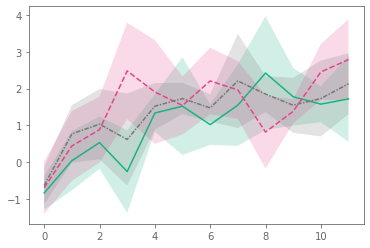

In [27]:
figure5b()

In [28]:
# Figure 5b with control and HVC groups merged
def fig5b_modified(ax: plt.Axes = None):
    """Plots odds-ratios for learning a new vocalizer set S2"""
    if ax is None:
        ax = plt.gca()

    print("Figure 5B modified: logOR by k")
    print("--------------------------------")
    for treatment in ["NCM", ("HVC", "CTRL")]:
        if isinstance(treatment, str):
            treatment_filter = df.SubjectTreatment == treatment
            plot_name = treatment
        elif isinstance(treatment, tuple):
            treatment_filter = np.zeros_like(df.SubjectTreatment).astype(bool)
            plot_name = "CTRL"  # TODO change this to new color?  in zf_data.constants
            for t in treatment:
                treatment_filter |= df.SubjectTreatment == t
                
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S2")
            & treatment_filter
        ], k_max=11)

        logOR = tsvk_treatment.logOR()

        shaded_line(
            logOR["k"], 
            logOR["logOR"], 
            2 * logOR["SE"],
            ax=ax,
            line_kwargs={
                "color": COLORMAP[plot_name],
                "linestyle": LINEMAP[plot_name]
            },
        )

        pvalues = logOR["pvalue"]        
        first_bin = np.where(false_discovery(pvalues, alpha=0.05))[0][0]
        
        print(f" The {treatment} group after lesion, being first exposed to S2")
        print("--------")
        print(f"  the smallest bin k where log2OR > 0 could be detected: k={first_bin}")        

        print(f"    k=0; {treatment}: logOR = {logOR['logOR'][0]:.2f}, t({logOR['dof'][0]}) = {logOR['tstat'][0]:.2f}, {parse_p(pvalues[0])}")
        print(f"    k=1; {treatment}: logOR = {logOR['logOR'][1]:.2f}, t({logOR['dof'][1]}) = {logOR['tstat'][1]:.2f}, {parse_p(pvalues[1])}")
        print()

Figure 5B modified: logOR by k
--------------------------------
 The NCM group after lesion, being first exposed to S2
--------
  the smallest bin k where log2OR > 0 could be detected: k=4
    k=0; NCM: logOR = -0.84, t(9) = -3.53, p = 0.997
    k=1; NCM: logOR = 0.04, t(9) = 0.09, p = 0.463

 The ('HVC', 'CTRL') group after lesion, being first exposed to S2
--------
  the smallest bin k where log2OR > 0 could be detected: k=2
    k=0; ('HVC', 'CTRL'): logOR = -0.67, t(10) = -2.63, p = 0.987
    k=1; ('HVC', 'CTRL'): logOR = 0.56, t(10) = 1.59, p = 0.072



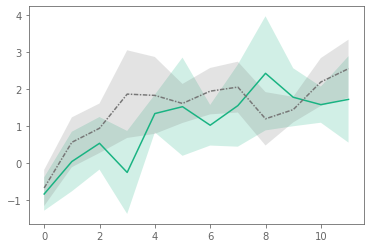

In [29]:
fig5b_modified()

In [30]:
# Now for Figure 5e, which will be effect of NCM lesion on LEARNING (compare to MEMORY/RECALL)

def fig5e(ax: plt.Axes = None):
    """Plots effect size of NCM lesion on learning a new vocalizer set
        NCM birds are compared to "control", which in this case is HVC + CTRL condition birds lumped together
        
        effect size = d' = (sqrt(2) * difference_in_logORs_CTRL-NCM) / normalized_variance
        
        specifically: 
                        difference_in_logORs_CTRL-NCM = logOR_CTRL - logOR_NCM
                        normalized_variance =  sqrt(var_NCM * (NCM_dof+1) + var_CTRL * (CTRL_dof+1) / 
                                                                ((NCM_dof+1) + (CTRL_dof+1)))
        """
    
    if ax is None:
        ax = plt.gca()

    print("Figure 5e : NCM lesion effect on learning")
    print("-----------------------------------------")
    print(" effect size = (sqrt(2) * difference_in_logORs_CTRL-NCM) / ")
    print("                  / normalized_variance ")
    print(" ")
    print(" Set 2 vocalizers")

    # create two separate tsvk instances, one for control group one for NCM

    tsvk_NCM = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S2")
        & (df.SubjectTreatment == "NCM")
    ], k_max=11)
    logOR_NCM = tsvk_NCM.logOR()
    
    treatment_filter = np.zeros_like(df.SubjectTreatment).astype(bool)
    for t in ("HVC", "CTRL"):
        treatment_filter |= df.SubjectTreatment == t
    
    tsvk_control = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S2")
        & treatment_filter
    ], k_max=11)
    logOR_CTRL = tsvk_control.logOR()
    
    # difference of the logORs
    diff_logOR = logOR_CTRL["logOR"]-logOR_NCM["logOR"]
    
    # normalization term
    nNCM = logOR_NCM["dof"] + 1
    nCTRL = logOR_CTRL["dof"] + 1
    var_NCM = logOR_NCM["SE"]**2 * nNCM 
    var_CTRL = logOR_CTRL["SE"]**2 * nCTRL
    norm_var = np.sqrt(var_NCM * nNCM + var_CTRL * nCTRL / (nNCM + nCTRL))
    
    # effect size of NCM lesion on memory
    d_prime = (np.sqrt(2) * diff_logOR) / norm_var
    
    # an attempt at an SE measurement for d'... I don't think this is right
    SE_average = np.sqrt((logOR_NCM["SE"]**2 * logOR_NCM["dof"] + logOR_CTRL["SE"]**2 * logOR_CTRL["dof"]) / (logOR_NCM["dof"] + logOR_CTRL["dof"]))
    
    shaded_line(
        logOR_NCM["k"], 
        d_prime, 
        SE_average/500, # I'm not actually sure what to calculate for SE here
        ax=ax,
        line_kwargs={
            "color": [1.0, 0.5, 0.25],
            "linestyle": LINEMAP["HVC"],
        }
    )

Figure 5e : NCM lesion effect on learning
-----------------------------------------
 effect size = (sqrt(2) * difference_in_logORs_CTRL-NCM) / 
                  / normalized_variance 
 
 Set 2 vocalizers


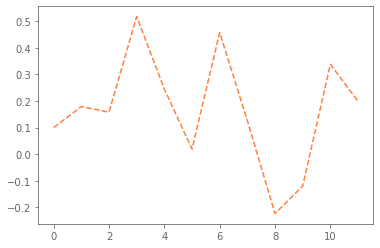

In [31]:
fig5e()

In [32]:
def EffectFig(ax: plt.Axes = None):
    """Plots effect size of NCM lesion during initial stage of ladder AFTER lesion
        NCM birds are compared to "control", which in this case is HVC + CTRL condition birds lumped together
        
        effect size = d' = (sqrt(2) * difference_in_logORs_CTRL-NCM) / normalized_variance
        
        specifically: 
                        difference_in_logORs_CTRL-NCM = logOR_CTRL - logOR_NCM
                        normalized_variance =  sqrt(var_NCM * (NCM_dof+1) + var_CTRL * (CTRL_dof+1) / 
                                                                ((NCM_dof+1) + (CTRL_dof+1)))
                                                                
        
        """
    if ax is None:
        ax = plt.gca()

    print("Figure 'Effect Size' : NCM lesion effect on recall and learning")
    print("---------------------------------------------------------------")
    print(" effect size = (sqrt(2) * difference_in_logORs_CTRL-NCM) / ")
    print("                  / normalized_variance ")
    print(" ")
    print(" Set 1 vocalizers (recall) = orange")
    print(" Set 2 vocalizers (learning) = yellow")

    # create two separate tsvk instances, one for control group one for NCM

    tsvk_NCM = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S1")
        & (df.SubjectTreatment == "NCM")
    ], k_max=11)
    logOR_NCM = tsvk_NCM.logOR()
    
    treatment_filter = np.zeros_like(df.SubjectTreatment).astype(bool)
    for t in ("HVC", "CTRL"):
        treatment_filter |= df.SubjectTreatment == t
    
    tsvk_control = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S1")
        & treatment_filter
    ], k_max=11)
    logOR_CTRL = tsvk_control.logOR()
    
    # difference of the logORs
    diff_logOR = logOR_CTRL["logOR"]-logOR_NCM["logOR"]
    
    # normalization term
    nNCM = logOR_NCM["dof"] + 1
    nCTRL = logOR_CTRL["dof"] + 1
    var_NCM = logOR_NCM["SE"]**2 * nNCM 
    var_CTRL = logOR_CTRL["SE"]**2 * nCTRL
    norm_var = np.sqrt(var_NCM * nNCM + var_CTRL * nCTRL / (nNCM + nCTRL))
    
    # effect size of NCM lesion on memory
    d_prime = (np.sqrt(2) * diff_logOR) / norm_var
    
    # an attempt at an SE measurement for d'... I don't think this is right
    SE_average = np.sqrt((logOR_NCM["SE"]**2 * logOR_NCM["dof"] + logOR_CTRL["SE"]**2 * logOR_CTRL["dof"]) / (logOR_NCM["dof"] + logOR_CTRL["dof"]))
    
    shaded_line(
        logOR_NCM["k"], 
        d_prime, 
        SE_average/500, # I'm not actually sure what to calculate for SE here
        ax=ax,
        line_kwargs={
            "color": [1.0, 0.5, 0.25],
            "linestyle": LINEMAP["HVC"],
        }
    )
    
# Now for Figure 5e, which will be effect of NCM lesion on LEARNING (compare to MEMORY/RECALL)

    learn_tsvk_NCM = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S2")
        & (df.SubjectTreatment == "NCM")
    ], k_max=11)
    learn_logOR_NCM = learn_tsvk_NCM.logOR()
    
    learn_tsvk_control = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S2")
        & treatment_filter
    ], k_max=11)
    learn_logOR_CTRL = learn_tsvk_control.logOR()
    
    # difference of the logORs
    learn_diff_logOR = learn_logOR_CTRL["logOR"]-learn_logOR_NCM["logOR"]
    
    # normalization term
    learn_nNCM = learn_logOR_NCM["dof"] + 1
    learn_nCTRL = learn_logOR_CTRL["dof"] + 1
    learn_var_NCM = learn_logOR_NCM["SE"]**2 * learn_nNCM 
    learn_var_CTRL = learn_logOR_CTRL["SE"]**2 * learn_nCTRL
    learn_norm_var = np.sqrt(learn_var_NCM * learn_nNCM + learn_var_CTRL * learn_nCTRL / (learn_nNCM + learn_nCTRL))
    
    # effect size of NCM lesion on memory
    learn_d_prime = (np.sqrt(2) * learn_diff_logOR) / learn_norm_var
    
    # an attempt at an SE measurement for d'... I don't think this is right
    SE_average = np.sqrt((logOR_NCM["SE"]**2 * logOR_NCM["dof"] + logOR_CTRL["SE"]**2 * logOR_CTRL["dof"]) / (logOR_NCM["dof"] + logOR_CTRL["dof"]))
    
    shaded_line(
        learn_logOR_NCM["k"], 
        learn_d_prime, 
        SE_average/500, # I'm not actually sure what to calculate for SE here
        ax=ax,
        line_kwargs={
            "color": [1.0, 0.75, 0.25],
            "linestyle": LINEMAP["HVC"],
        }
    )

Figure 'Effect Size' : NCM lesion effect on recall and learning
---------------------------------------------------------------
 effect size = (sqrt(2) * difference_in_logORs_CTRL-NCM) / 
                  / normalized_variance 
 
 Set 1 vocalizers (recall) = orange
 Set 2 vocalizers (learning) = yellow


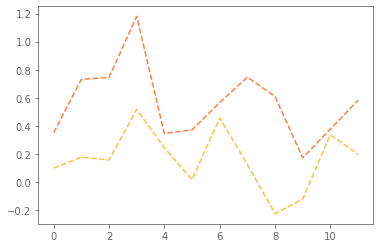

In [33]:
EffectFig()